In [10]:
import tensorflow as tf

In [11]:
num_classes = 80

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "F:/Dataset/Medicinal Leaf dataset",
    shuffle=True,
    batch_size=32,
    image_size=(224, 224),
)

labels = dataset.class_names
labels
num_classes = len(labels)
print("Number of classes:", num_classes)

Found 401 files belonging to 3 classes.
Number of classes: 3


In [13]:
import numpy as np

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    break

(32, 224, 224, 3)
[1 0 2 0 1 2 1 1 0 2 0 2 2 1 1 2 2 2 0 1 0 0 1 1 1 0 1 1 2 0 1 2]


In [14]:
# train test split
train_size = int(0.8 * len(dataset))
test_size = int(0.2 * len(dataset))
train_size, test_size

(10, 2)

In [15]:
def get_dataset_partisions_tf(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * len(ds))
    test_size = int(test_split * len(ds))
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    val_ds = test_ds.skip(test_size)
    test_ds = test_ds.take(test_size)
    return train_ds, test_ds, val_ds

In [16]:
train_ds, test_ds, val_ds = get_dataset_partisions_tf(dataset)
len(train_ds), len(test_ds), len(val_ds)

(10, 2, 1)

In [17]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [18]:
input_shape = (224, 224, 3)


In [19]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# from patchify import patchify
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
# import vit
import os
import numpy as np
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [20]:
from tensorflow.keras.applications import MobileNetV2

MobileNetV2_model = MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)


for layer in MobileNetV2_model.layers:
    layer.trainable = True

x = GlobalAveragePooling2D()(MobileNetV2_model.output)
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=MobileNetV2_model.input, outputs=output)

In [21]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=20
)

Epoch 1/20
10/10 [==============================] - 157s 12s/step - loss: 0.4767 - accuracy: 0.7967 - val_loss: 3.4559 - val_accuracy: 0.4375
Epoch 2/20
10/10 [==============================] - 118s 11s/step - loss: 0.0979 - accuracy: 0.9875 - val_loss: 10.3814 - val_accuracy: 0.4688
Epoch 3/20
10/10 [==============================] - 160s 16s/step - loss: 0.1225 - accuracy: 0.9770 - val_loss: 31.1836 - val_accuracy: 0.3125
Epoch 4/20
10/10 [==============================] - 174s 19s/step - loss: 0.0974 - accuracy: 0.9738 - val_loss: 35.0223 - val_accuracy: 0.3438
Epoch 5/20
10/10 [==============================] - 180s 17s/step - loss: 0.0706 - accuracy: 0.9836 - val_loss: 45.6056 - val_accuracy: 0.1875
Epoch 6/20
10/10 [==============================] - 190s 19s/step - loss: 0.1023 - accuracy: 0.9803 - val_loss: 44.3333 - val_accuracy: 0.3750
Epoch 7/20
10/10 [==============================] - 143s 14s/step - loss: 0.1872 - accuracy: 0.9311 - val_loss: 43.4651 - val_accuracy: 0.4688


In [23]:
model.evaluate(test_ds)

2/2 [==============================] - 4s 2s/step - loss: 21.2317 - accuracy: 0.2500


[21.231725692749023, 0.25]

In [40]:
# predict with new images
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    'F:/Dataset/Medicinal Leaf dataset/Aloevera/328.jpg', target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
# Assuming dataset.class_names is a list of class names
labels = dataset.class_names
# Verify the number of classes
num_classes = len(labels)
print("Number of classes:", num_classes)

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
# Get the predicted class index
predicted_class_index = np.argmax(score)
# Debugging: Print the predicted class index
print("Predicted class index:", predicted_class_index)
# Check if the predicted class index is within the range of labels list
if predicted_class_index < num_classes:
    predicted_label = labels[predicted_class_index]
    confidence = 100 * np.max(score)
    print("Predicted class:", predicted_label)
    print("Confidence:", confidence, "%")
else:
    print("Error: Predicted class index out of range.")

Number of classes: 3
1/1 [==============================] - 0s 208ms/step
Predicted class index: 0
Predicted class: Aloevera
Confidence: 73.10585975646973 %


In [25]:
# predict with new images
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    'F:/Dataset/Medicinal Leaf dataset/Betel/335.jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
# Assuming dataset.class_names is a list of class names
labels = dataset.class_names
# Verify the number of classes
num_classes = len(labels)
print("Number of classes:", num_classes)
# Make predictions
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
# Get the predicted class index
predicted_class_index = np.argmax(score)

# Debugging: Print the predicted class index
print("Predicted class index:", predicted_class_index)

# Check if the predicted class index is within the range of labels list
if predicted_class_index < num_classes:
    predicted_label = labels[predicted_class_index]
    confidence = 100 * np.max(score)
    print("Predicted class:", predicted_label)
    print("Confidence:", confidence, "%")
else:
    print("Error: Predicted class index out of range.")

Number of classes: 3
1/1 [==============================] - 0s 98ms/step
Predicted class index: 1
Predicted class: Betel
Confidence: 73.10585975646973 %


In [51]:
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    'F:/Dataset/Medicinal Leaf dataset/Neem/888.jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
# Assuming dataset.class_names is a list of class names
labels = dataset.class_names
# Verify the number of classes
num_classes = len(labels)
print("Number of classes:", num_classes)
# Make predictions
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
# Get the predicted class index
predicted_class_index = np.argmax(score)
# Debugging: Print the predicted class index
print("Predicted class index:", predicted_class_index)

# Check if the predicted class index is within the range of labels list
if predicted_class_index < num_classes:
    predicted_label = labels[predicted_class_index]
    confidence = 100 * np.max(score)
    print("Predicted class:", predicted_label)
    print("Confidence:", confidence, "%")
else:
    print("Error: Predicted class index out of range.")

Number of classes: 3
1/1 [==============================] - 0s 83ms/step
Predicted class index: 0
Predicted class: Aloevera
Confidence: 73.10585975646973 %


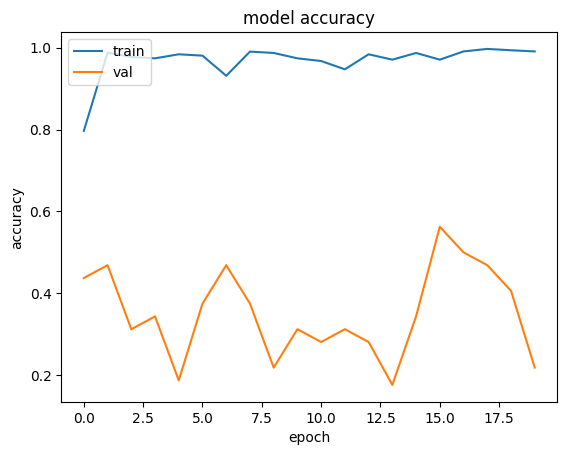

In [27]:
# plot accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
model.save('model_avg_20_inception.h5')


c:\Program Files\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
pip install visualkeras

  Using cached visualkeras-0.0.2-py3-none-any.whl.metadata (5.9 kB)
  Using cached aggdraw-1.3.16-cp38-cp38-win_amd64.whl.metadata (706 bytes)
Using cached visualkeras-0.0.2-py3-none-any.whl (12 kB)
Using cached aggdraw-1.3.16-cp38-cp38-win_amd64.whl (43 kB)
Note: you may need to restart the kernel to use updated packages.


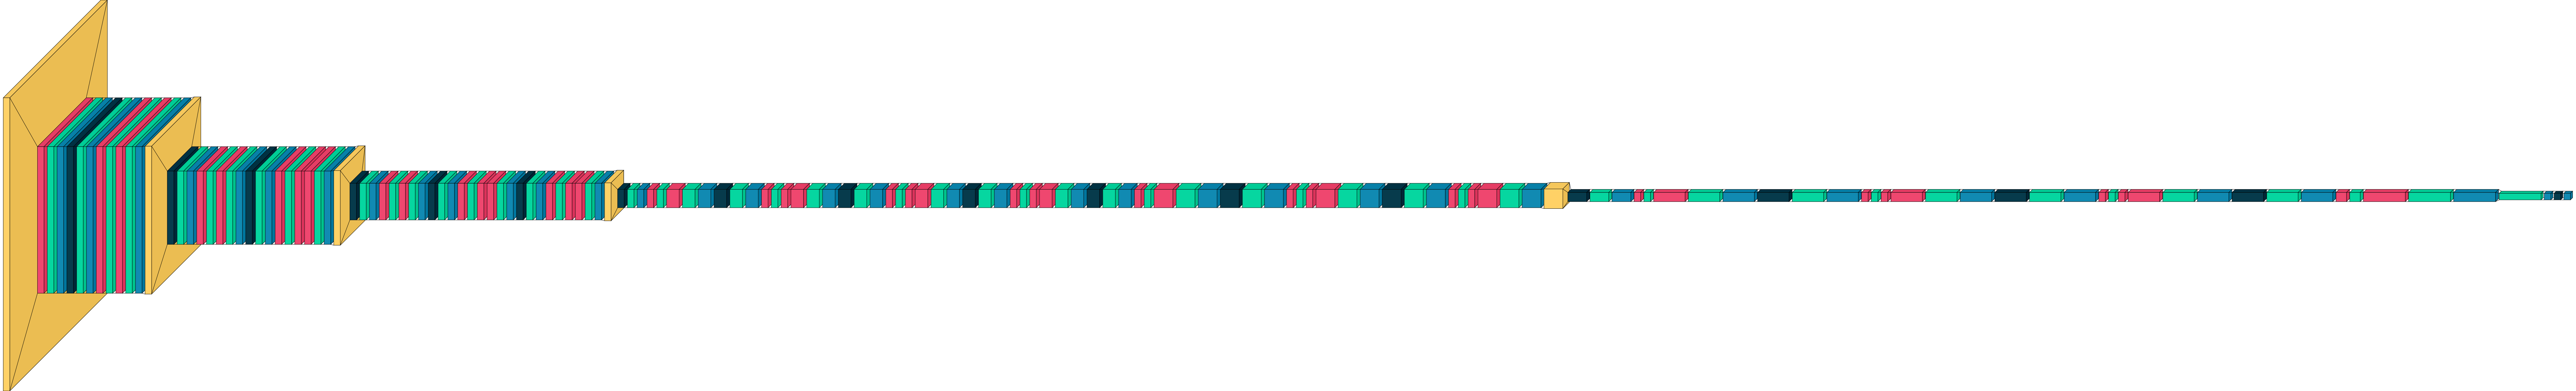

In [30]:
import visualkeras
visualkeras.layered_view(model)


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import seaborn
import tensorflow as tf
from tensorflow.keras import Sequential, optimizers, losses, layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import keras

In [32]:
model1 = keras.Sequential([
    keras.layers.Input(shape=(22,)),
    keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5), 
    keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dense(20, activation='sigmoid')
    ])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
visualkeras.layered_view(model1)